In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import hickle

from ase.io import read

import numpy as np

import torch
torch.set_default_dtype(torch.float64)

from mlelec.data.dataset import QMDataset
from mlelec.data.mldataset import MLDataset
from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.utils.pbc_utils import blocks_to_matrix
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, unfix_orbital_order
from mlelec.metrics import Eigval_loss, L2_loss_meanzero, L2_loss
import metatensor.torch as mts
from metatensor.learn import DataLoader

import os
os.environ["PYSCFAD_BACKEND"] = "torch"
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol

import xitorch
from xitorch.linalg import symeig

from matplotlib import pyplot as plt

from IPython.utils import io as ipy_io

Using PyTorch backend.


/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
def compute_eigval_vec(dataset, batch, Hk, return_rho = False, return_eigenvectors = False):
    eig = []
    rho = []
    eigvec = []
    for A, H, S in zip(batch.sample_id, Hk, batch.overlap_realspace):
        # Compute eigenvalues and eigenvectors
        # eigvals, eigvecs = symeig(Ax, M = Mx)
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M = xitorch.LinearOperator.m(S))
        if return_rho:
            frame = dataset.structures[A]
            natm = len(frame)
            ncore = sum(dataset.ncore[s] for s in frame.numbers)
            nelec = sum(frame.numbers) - ncore
            occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            # occ = torch.tensor([2.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
            rho.append(torch.einsum('n,...in,...jn->ij...', occ, C, C.conj()))
        eig.append(eigvals)
        if return_eigenvectors:
            eigvec.append(C)

    to_return = [eig]
    if return_rho:
        try:
            rho = torch.stack(rho)
        except:
            pass
        to_return.append(rho)
    if return_eigenvectors:
        try:
            eigvec = torch.stack(eigvec)
        except:
            pass
        to_return.append(eigvec)
    return tuple(to_return)

def compute_ard_vec(dataset, batch, HT, device, overlap = None):
    basis = dataset.basis
    ard_ = []
    eig = []
    Cs = []
    rhos = []

    overlap = batch.overlap_realspace if overlap is None else overlap
    
    for A, H, S in zip(batch.sample_id, HT, overlap):
        frame = dataset.structures[A]
        natm = len(frame)
        ncore = sum(dataset.ncore[s] for s in frame.numbers)
        nelec = sum(frame.numbers) - ncore
        split_idx = [len(basis[s]) for s in frame.numbers]
        needed = True if len(np.unique(split_idx)) > 1 else False
        
        max_dim = np.max(split_idx)
        
        eigvals, C = symeig(xitorch.LinearOperator.m(H), M=xitorch.LinearOperator.m(S), return_eigenvectors = True) # Has shape = (n_k, N, N)
        
        occ = torch.tensor([2.0 if i < nelec//2 else 0.0 for i in range(C.shape[-1])], dtype = torch.float64, requires_grad = True, device = device)
        P = torch.einsum('n,...in,...jn->ij...', occ, C, C.conj())
        rhos.append(P)
        
        slices = torch.split(P, split_idx, dim=0)
        blocks = [torch.split(slice_, split_idx, dim=1) for slice_ in slices]
        blocks_flat = [block for sublist in blocks for block in sublist]
        
        if needed:
            squared_blocks = []
            for block in blocks_flat:
                pad_size = (0, max_dim - block.size(1), 0, max_dim - block.size(0))
                squared_block = torch.nn.functional.pad(block, pad_size, "constant", 0)
                squared_blocks.append(squared_block)
            blocks_flat = squared_blocks


        ard_.append(torch.stack(blocks_flat).norm(dim=(1,2)))
        eig.append(eigvals)
        Cs.append(C)

    try:
        ard_ = torch.stack(ard_)
    except:
        pass
    try:
        eig = torch.stack(eig)
    except:
        pass
    try:
        rhos = torch.stack(rhos)
    except:
        pass
    try:
        Cs = torch.stack(Cs)
    except:
        pass
    
    return eig, ard_, Cs, rhos

def compute_dipole_moment(frames, fock_predictions, overlaps, basis = 'sto-3g'):
    assert (
        len(frames) == len(fock_predictions) == len(overlaps)
    ), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame, basis = basis)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(
            fock_predictions[i].type(torch.float64), requires_grad=True
        )

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy)  # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [4]:
orbitals = {
    'sto-3g': {1: [[1,0,0]], 
               5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
               8: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]
               }, 
    
    'def2svp': {1: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]],
                6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]],
                8: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]
                },

    'def2-tzvp': {1: [[1, 0, 0], [2, 0, 0], [3, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]],
                  6: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]],
                  7: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]],
                  8: [[1, 0, 0],[2, 0, 0],[3, 0, 0],[4, 0, 0],[5, 0, 0],
                      [2, 1, 1],[2, 1, -1],[2, 1, 0],[3, 1, 1],[3, 1, -1],[3, 1, 0],[4, 1, 1],[4, 1, -1],[4, 1, 0],
                      [3, 2, -2],[3, 2, -1],[3, 2, 0],[3, 2, 1],[3, 2, 2],[4, 2, -2],[4, 2, -1],[4, 2, 0],[4, 2, 1],[4, 2, 2],
                      [4, 3, -3],[4, 3, -2],[4, 3, -1],[4, 3, 0],[4, 3, 1],[4, 3, 2],[4, 3, 3]]
                 }
}
device = 'cpu'

In [5]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
cutoff = 3.5

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}

hypers_atom = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.5,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.5}}}


return_rho0ij = False
both_centers = False
LCUT = 4

In [6]:
workdir = '../examples/data/qm7'
every = 4
frames = read(f'{workdir}/qm7.xyz', ':1000')
frames = frames[::every]

FileNotFoundError: [Errno 2] No such file or directory: '../examples/data/qm7/qm7.xyz'

For the moment, we need to create multiple QMDataset (analogous to MoleculeDataset), one for the large basis, one for the small one.

In [7]:
fock = hickle.load(f'{workdir}/def2-tzvp/fock.hickle')[::every]
fock = [torch.from_numpy(f) for f in fock]
over = hickle.load(f'{workdir}/def2-tzvp/overlap.hickle')[::every]
over = [torch.from_numpy(o) for o in over]

In [8]:
qmdata = QMDataset(frames = frames, 
                   fix_p_orbital_order=True, # Needed for pyscf
                   dimension = 0,            # For molecules
                   fock_realspace=fock,
                   overlap_realspace=list(over),
                   device = device, 
                   orbs = orbitals['def2-tzvp'], 
                   orbs_name = 'def2-tzvp'
                )

In [9]:
fock_small = hickle.load(f'{workdir}/sto-3g/fock.hickle')[::every]
fock_small = [torch.from_numpy(f) for f in fock_small]
over_small = hickle.load(f'{workdir}/sto-3g/overlap.hickle')[::every]
over_small = [torch.from_numpy(o) for o in over_small]

qmdata_sto3G = QMDataset(frames = frames, 
                         fix_p_orbital_order=True,
                         dimension = 0,
                         fock_realspace=fock_small,
                         overlap_realspace=list(over_small),
                         device = device, 
                         orbs = orbitals['sto-3g'], 
                         orbs_name = 'sto-3g'
                        )

In [ ]:
mldata = MLDataset(qmdata, 
                   item_names = ['fock_blocks', 'fock_realspace', 'overlap_realspace', 'eigenvalues', 'atom_resolved_density'],
                   cutoff = hypers_pair['cutoff'],
                   hypers_atom = hypers_atom,
                   hypers_pair = hypers_pair,
                   lcut = 3,
                   orbitals_to_properties = True,
                   train_frac = 0.7,
                   val_frac = 0.2,
                   test_frac = 0.1
                  )

cpu pair features
cpu single center features
cpu single center features
Features set
Items set


The following cell is required to compute the metadata used to initialize the model (i.e., the model's submodels info)

In [11]:
mldata._compute_model_metadata(qmdata_sto3G)

Instantiate the dataloader

In [12]:
dl = DataLoader(mldata.train_dataset, batch_size = 10, collate_fn = mldata.group_and_join)

# Train

Initialize the model

In [19]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = mldata.features, 
                            target_blocks = mldata.model_metadata,
                            frames = qmdata.structures, 
                            orbitals = qmdata_sto3G.basis, 
                            device = device,
                            nhidden = 3, 
                            nlayers = 1,
                            activation = 'SiLU',
                           apply_norm = True
                           )
model = model.double()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-3, weight_decay = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience = 20)

In [41]:
def mse_qm7(frames, pred, target):
    norm_loss = []
    for i in range(len(pred)):
        norm_loss.append((torch.linalg.norm(pred[i] - target[i]))**2/(frames[i].get_global_number_of_atoms()**2))
    return torch.mean(torch.stack(norm_loss))

In [42]:
# N. of eigenvalues to match (this needs to be adapted for diverse datasets
n_eig_to_match = 5

In [43]:
nepoch = 1000
losses = []
losses_eva = []
losses_ard = []
losses_evec = []

In [48]:
for epoch in range(nepoch):

    epoch_loss = 0
    epoch_loss_eva = 0
    epoch_loss_evec = 0
    epoch_loss_ard = 0
    eig_sum = 0
    

    for ib, batch in enumerate(dl):
        
        model.train(True)
        optimizer.zero_grad()
        
        pred = model.forward(batch.features, mldata.model_metadata)

        HT = blocks_to_matrix(pred, qmdata_sto3G, detach = False)
        HT = [HT[i][0,0,0] for i in batch.sample_id] # Required for now

        pred_eigvals, pred_ard, pred_C, _ = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])
        ref_eigvals = [batch.eigenvalues[i][:pred_eigvals[i].shape[0]] for i in range(len(HT))]

        #qm7_loss
        structs = [mldata.structures[i] for i in batch.sample_id]
        loss_eva = mse_qm7(structs, pred_eigvals, ref_eigvals)
        loss_ard = mse_qm7(structs, pred_ard, list(batch.atom_resolved_density))
        
        
        # loss_e = Eigval_loss(pred_eigvals, ref_eigvals)
        # loss_ard = sum(torch.sum((pred_ard[i] - list(batch.atom_resolved_density)[i])**2) for i in range(len(HT)))
        pred_ev_0 = [torch.norm(pred_C[i][:, :], dim=(0)) for i in range(len(HT))]
        targ_ev_0 = [torch.norm(batch.eigenvectors[i][:, :pred_C[i].shape[0]], dim=(0)) for i in range(len(HT))]

        loss_evec = mse_qm7(structs, pred_ev_0, targ_ev_0)
        # loss_evec = sum(torch.sum((pred_ev_0[i] - targ_ev_0[i])**2) for i in range(len(HT)))
        
        loss = loss_ard + loss_eva + 10*loss_evec
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()

        epoch_loss_eva += loss_eva.item()
        epoch_loss_evec += loss_evec.item()
        epoch_loss_ard += loss_ard.item()
        epoch_loss += loss.item()
        
    scheduler.step(epoch_loss)
    losses.append(epoch_loss)
    losses_eva.append(epoch_loss_eva)
    losses_evec.append(epoch_loss_evec)
    losses_ard.append(epoch_loss_ard)
    
    if epoch >= 0: #% 10 == 0:
        print(f"Epoch {epoch:>7d}, train loss {epoch_loss:>15.10f}; rmse_eig={np.sqrt(epoch_loss_eva):>12.10f} rmse_evec={np.sqrt(epoch_loss_evec):>12.10f} rmse_ard={np.sqrt(epoch_loss_ard):>12.10f} ")

Epoch       0, train loss 1046.2008028898; rmse_eig=2.4853564777 rmse_evec=10.1898797705 rmse_ard=1.2989644673 
Epoch       1, train loss 1046.0769696209; rmse_eig=2.4208287006 rmse_evec=10.1915957574 rmse_ard=1.2370598992 
Epoch       2, train loss 1044.7310625987; rmse_eig=2.3067129267 rmse_evec=10.1873383149 rmse_ard=1.2615540597 
Epoch       3, train loss 1044.0369337466; rmse_eig=2.1925719879 rmse_evec=10.1863945440 rmse_ard=1.2661847238 
Epoch       4, train loss 1042.3260808307; rmse_eig=2.1397877638 rmse_evec=10.1799325122 rmse_ard=1.1988034154 
Epoch       5, train loss 1043.5707349138; rmse_eig=2.2086676668 rmse_evec=10.1841633602 rmse_ard=1.2331620230 
Epoch       6, train loss 1044.2541365686; rmse_eig=2.2795006967 rmse_evec=10.1865115804 rmse_ard=1.1865206998 
Epoch       7, train loss 1043.0002407587; rmse_eig=2.2960752821 rmse_evec=10.1797893307 rmse_ard=1.2029841596 
Epoch       8, train loss 1042.2829474288; rmse_eig=2.1816057476 rmse_evec=10.1791688942 rmse_ard=1.1699

KeyboardInterrupt: 

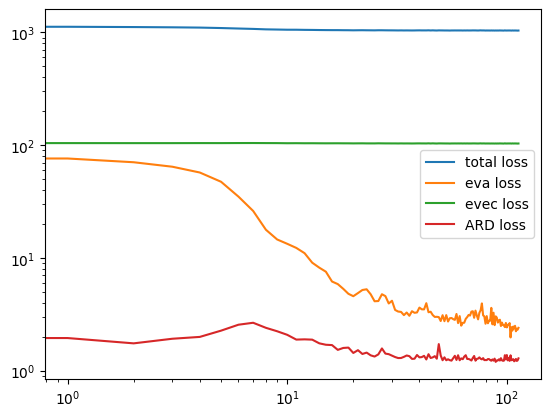

In [49]:
plt.loglog(losses, label="total loss")
plt.loglog(losses_eva, label="eva loss",)
plt.loglog(losses_evec, label="evec loss")
plt.loglog(losses_ard, label="ARD loss")
plt.legend()

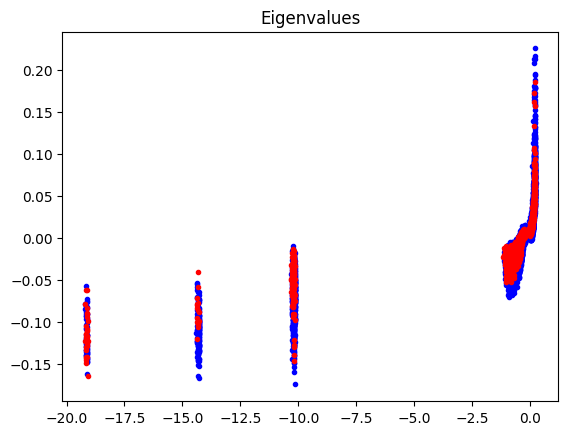

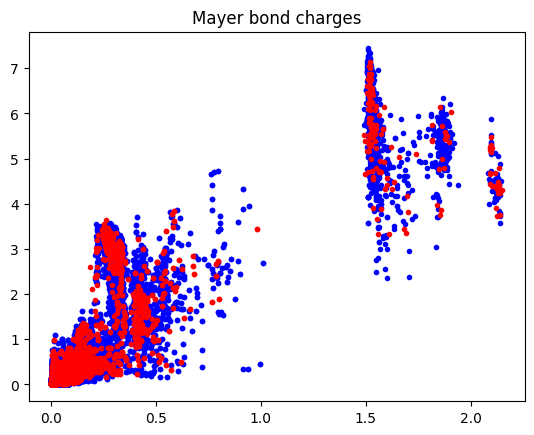

In [40]:
test_dl = DataLoader(mldata.test_dataset, batch_size = len(mldata.test_dataset), collate_fn=mldata.group_and_join)
train_dl = DataLoader(mldata.train_dataset, batch_size = len(mldata.train_dataset), collate_fn=mldata.group_and_join)

fig_e, ax_e = plt.subplots()
fig_a, ax_a = plt.subplots()
fig_evec, ax_evec = plt.subplots()
colors = {'train': 'blue', 'test': 'red'}

data = {}
for dl_, lbl in zip([train_dl, test_dl], ['train', 'test']):
    batch = next(iter(dl_))
    pred = model(batch.features, mldata.model_metadata)

    HT = blocks_to_matrix(pred, qmdata_sto3G, detach = True)
    HT = [HT[i][0,0,0] for i in batch.sample_id]

    pred_eigvals, pred_ard, pred_eigvec, pred_rho = compute_ard_vec(qmdata_sto3G, batch, HT, device, overlap = [qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id])
    
    for true_eigvals, pred_eigvals_tensor in zip([batch.eigenvalues[i][:pred_eigvals[i].shape[0]] for i in range(len(HT))], pred_eigvals):
        ax_e.plot(true_eigvals.flatten().detach().numpy(), 
              pred_eigvals_tensor.detach().flatten().detach().numpy(), 
              '.', label=lbl, color=colors[lbl])
    ax_e.plot([-21, 2], [-21, 2], 'k')
    ax_e.set_title('Eigenvalues')
    # ax_e.legend()

    for target, pred in zip(list(batch.atom_resolved_density), pred_ard):
        ax_a.plot(target.flatten().detach().numpy(), pred.flatten().detach().numpy(), '.', label = lbl, color=colors[lbl])
    ax_a.plot([0,7], [0,7], 'k')
    ax_a.set_title('Mayer bond charges')
    # ax_a.legend()
    
    pred_evn = [torch.norm(pred_eigvec[i][:, :], dim=(0)) for i in range(len(HT))]
    targ_evn = [torch.norm(batch.eigenvectors[i][:, :pred_C[i].shape[0]], dim=(0)) for i in range(len(HT))]

    for target, pred in zip(targ_evn, pred_evn):
        ax_evec.plot(target.flatten().detach().numpy(), pred.flatten().detach().numpy(), '.', label = lbl, color=colors[lbl])

    xmin, xmax = ax_evec.get_xlim()
    ymin, ymax = ax_evec.get_ylim()
    xmin = np.min([xmin,ymin])
    xmax = np.max([xmax,ymax])
    ax_evec.plot([xmin,xmax], [xmin,xmax], 'k')
    ax_evec.set_title('evec')
    # ax_evec.legend()

In [ ]:
batch = next(iter(test_dl))
print(batch.sample_id)
dl_frames = [qmdata.structures[A] for A in batch.sample_id]

pred = model(batch.features, mldata.model_metadata)

HT = blocks_to_matrix(pred, qmdata_sto3G, detach = True)
HT = [HT[i][0,0,0] for i in batch.sample_id]

# fock_predictions = torch.stack(HT)
fock_predictions = HT

fock_predictions = unfix_orbital_order(
    fock_predictions,
    dl_frames,
    qmdata_sto3G.basis,
)

fock_targets = unfix_orbital_order(
    batch.fock_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

fock_sto3g = unfix_orbital_order(
    qmdata_sto3G.fock_realspace,
    dl_frames,
    qmdata_sto3G.basis,
)

over_large = unfix_orbital_order(
    batch.overlap_realspace,
    dl_frames,
    mldata.qmdata.basis,
)

over_small = unfix_orbital_order(
    torch.stack([qmdata_sto3G.overlap_realspace[i] for i in batch.sample_id]),
    dl_frames,
    qmdata_sto3G.basis,
)

with ipy_io.capture_output():
    dipole_targets = compute_dipole_moment(
        dl_frames,
        fock_targets,
        over_large,
        qmdata.basis_name
    )

with ipy_io.capture_output():
    dipole_predictions = compute_dipole_moment(
        dl_frames,
        fock_predictions,
        over_small,
        qmdata_sto3G.basis_name
    )

with ipy_io.capture_output():
    dipole_sto3g = compute_dipole_moment(
        dl_frames,
        fock_sto3g,
        over_small,
        qmdata_sto3G.basis_name
    )

In [ ]:
from ase.units import Bohr, Debye
au_to_debye = Bohr/Debye

ms = 12
mew = .7

fig, ax = plt.subplots()

x = dipole_targets.flatten().detach().cpu() * au_to_debye
y_sto3g = dipole_sto3g.flatten().detach().cpu() * au_to_debye
y_ml = dipole_predictions.flatten().detach().cpu() * au_to_debye

rmse_sto3g = np.sqrt(torch.mean(y_sto3g - x)**2)
rmse_ml = np.sqrt(torch.mean(y_ml - x)**2)

ax.plot(x, y_sto3g, 'v', 
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'STO-3G', 
         alpha = 1)

ax.plot(x, y_ml, 'o',
         markeredgewidth = mew,
         markeredgecolor = 'k',
         markersize = ms, 
         label = 'ML', 
         alpha = 1)

ax.legend()

xm, xM = ax.get_xlim()
ym, yM = ax.get_ylim()
m = np.min([xm,ym])
M = np.max([xM,yM])
ax.plot([m,M], [m,M], '--k')
ax.set_xlim(m, M)
ax.set_ylim(m, M)

ax.text(0.6, 0.3, fr'$\mathrm{{RMSE_{{\text{{STO-3G}}}}}}={rmse_sto3g:.3f}\,$D', transform = ax.transAxes, ha = 'left')
ax.text(0.6, 0.25, f'$\mathrm{{RMSE_{{ML}}}}={rmse_ml:.3f}\,$D', transform = ax.transAxes, ha = 'left')

ax.set_xlabel('Target dipoles (D)')
ax.set_ylabel('Predicted dipoles (D)')

# ax.set_title('Indirect training from def2-svp to a STO-3G-like model.\nTargets: eigenvalues; ARD; eigenvector norms over AOs\nTest set contains 50 water molecules')